In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from preprocess import Preprocess
import tensorflow as tf
import rrn

from sklearn.cluster import KMeans, spectral_clustering
from sklearn.decomposition import PCA

/Users/larry/Py3/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


# Load Data and user/item vectors

In [2]:
df = pd.read_csv('../data/class/rating_data.csv')
df['freq'] = df.groupby('uid')['uid'].transform('count')  # count frequncy by column's values
df = df[df['freq'] > 5]  # remove row which corresponding frequence < 5
df_array = df.as_matrix()

user_vectors = np.load('../data/class/user_vectors.npy')
item_vectors = np.load('../data/class/item_vectors.npy')

user_time_interval = 3 * 30
item_time_interval = 3 * 30

# Top List preprocess

In [3]:
df_item = pd.DataFrame(df['iid'])
df_item.column = ['iid']
df_item['freq'] = df_item.groupby('iid')['iid'].transform('count')
df_item = df_item.drop_duplicates()
df_item = df_item.sort_values(by=['freq'], ascending=False)
top_list = df_item['iid'].as_matrix()

top_ranks = []
for i in range(1, 10):
    top_ranks.append(top_list[:i*10])

# Data preprocessing

In [4]:
import math
def get_map(list_):
    map_ = {}
    for idx, ident in enumerate(list_):
        map_[ident] = idx
        
    return map_

def train_test_split(df, time_interval, start_time, end_time, split_rate= 0.125):
    # start_time = min(df['timestamp'])
    # end_time = max(df['timestamp'])
    time_elapse = (end_time-start_time) // time_interval
    split_time = start_time + math.floor(time_elapse * (1-split_rate)) * time_interval
    train_time_elapse = math.floor(time_elapse * (1-split_rate))
    test_time_elapse = time_elapse - train_time_elapse + 1
    
    df_train = df[df['timestamp'] < split_time]
    df_test = df[df['timestamp'] >= split_time]
    
    return df_train, df_test, train_time_elapse, test_time_elapse, split_time

In [5]:
total_userList = np.unique(df['uid'])
total_itemList = np.unique(df['iid'])
user_map = get_map(total_userList)
item_map = get_map(total_itemList)
initial_time = min(df['timestamp'])

# Clustering

In [10]:
total_usr = len(total_userList)
total_item = len(total_itemList)

rating = np.zeros((total_usr, total_item), dtype=np.float32)
for line in df_array:
    uid = user_map[line[0]]
    iid = item_map[line[1]]
    rating[uid, iid] = 1

In [11]:
pca = PCA(n_components=10, svd_solver='full')
pca_out = pca.fit_transform(user_vectors)
NUM_CLUSTER = 10
kmeans = KMeans(n_clusters=NUM_CLUSTER, n_init=20, algorithm='full')


kmeans.fit(pca_out)

KMeans(algorithm='full', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=10, n_init=20, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [12]:
label_map = {}
for i in kmeans.labels_:
    if i not in label_map:
        label_map[i] = 1
    else:
        label_map[i] += 1

print (label_map)

{3: 106, 6: 146, 0: 74, 5: 139, 2: 103, 4: 38, 7: 80, 9: 35, 1: 80, 8: 38}


In [13]:
label_index = {}
for i in range(12):
    label_index[i] = []
    
label_list = list(kmeans.labels_)

for idx, i in enumerate(label_list):
    label_index[i].append(idx)

### Add cluster label to dataframe

In [14]:
df_new = df
df_new['label'] = -1

for i in range(NUM_CLUSTER):
    for j in label_index[i]:
        df_new.loc[df_new['uid'] == j+1, 'label'] = i

## rrn

In [15]:
def get_hparas(batch_size, vector_length, time_interval, train_time_elapse, test_time_elapse, name):
    hparas={
        'NAME': name,
        'EMBED_UNITS': 40,
        'BATCH_SIZE': batch_size,
        'LSTM_UNITS': 40,
        'LATENT_UNITS': 20,
        'VECTOR_LENGTH': vector_length+3,
        'TRAIN_TIME_ELAPSE': train_time_elapse,
        'TEST_TIME_ELAPSE': test_time_elapse,
        'STATIONARY_LENGTH': 20,
        'TIME_INTERVAL': time_interval,
    }
    
    return hparas

In [21]:
cluster_rmse = []
start_time = min(df['timestamp'])
end_time = max(df['timestamp'])

for i in range(NUM_CLUSTER):
    df_I = df_new[df_new['label'] == i]
    userList_I = np.unique(df_I['uid'])
    itemList_I = np.unique(df_I['iid'])
    
    user_cluster_map = get_map(userList_I)
    item_cluster_map = get_map(itemList_I)
    
    all_user_item_num = (len(total_userList), len(total_itemList))
    
    df_train_I, df_test_I, train_time_elapse, test_time_elapse, test_start_time \
    = train_test_split(df_I, user_time_interval * 24 * 3600, start_time, end_time)
    item_train_list = np.unique(df_train_I['iid'])
    user_train_list = np.unique(df_train_I['uid'])
    item_test_list = np.unique(df_test_I['iid'])
    user_test_list = np.unique(df_test_I['uid'])
    
    user_train_hparas = get_hparas(len(user_train_list), len(total_itemList), user_time_interval, train_time_elapse, test_time_elapse, 'USER')
    item_train_hparas = get_hparas(len(item_train_list), len(total_userList), item_time_interval, train_time_elapse, test_time_elapse, 'ITEM')
    user_test_hparas = get_hparas(len(user_test_list), len(total_itemList), user_time_interval, train_time_elapse, test_time_elapse, 'USER')
    item_test_hparas = get_hparas(len(item_test_list), len(total_userList), item_time_interval, train_time_elapse, test_time_elapse, 'ITEM')
    
    tf.reset_default_graph()
    
    model = rrn.RRN(user_hparas=user_train_hparas, item_hparas=item_train_hparas, 
                    user_vectors=user_vectors, item_vectors=item_vectors,
                    is_train=True, lr=0.01, epochs=1000, loss_function='rmse', weighted=None)
    
    model.model_load('class_rmse')
    
    model.train(df_train_I, user_map, item_map, initial_time, all_user_item_num,
                user_cluster_map=user_cluster_map, 
                item_cluster_map=item_cluster_map, top_rank=None)
    model.model_save('class_rmse_%d' % (i))
    
    tf.reset_default_graph()
    
    model = rrn.RRN(user_hparas=user_test_hparas, item_hparas=item_test_hparas, 
                    user_vectors=user_vectors, item_vectors=item_vectors,
                    is_train=False, lr=0.01, epochs=200, loss_function='rmse', weighted=None)
    
    model.model_load('class_rmse_%d' % (i))
    test_I = model.test(df_test_I, user_map, item_map, initial_time, test_start_time, 
                        all_user_item_num, user_cluster_map, item_cluster_map)
    
    cluster_rmse.append(sum(test_I)/len(test_I))

INFO:tensorflow:Restoring parameters from model/rrn_class_rmse.ckpt


100%|██████████| 1000/1000 [02:04<00:00,  8.04it/s]


INFO:tensorflow:Restoring parameters from model/rrn_class_rmse_0.ckpt
INFO:tensorflow:Restoring parameters from model/rrn_class_rmse.ckpt


100%|██████████| 1000/1000 [01:20<00:00, 12.35it/s]


INFO:tensorflow:Restoring parameters from model/rrn_class_rmse_1.ckpt
INFO:tensorflow:Restoring parameters from model/rrn_class_rmse.ckpt


100%|██████████| 1000/1000 [01:50<00:00,  9.09it/s]


INFO:tensorflow:Restoring parameters from model/rrn_class_rmse_2.ckpt
INFO:tensorflow:Restoring parameters from model/rrn_class_rmse.ckpt


100%|██████████| 1000/1000 [01:46<00:00,  9.41it/s]


INFO:tensorflow:Restoring parameters from model/rrn_class_rmse_3.ckpt
INFO:tensorflow:Restoring parameters from model/rrn_class_rmse.ckpt


100%|██████████| 1000/1000 [00:59<00:00, 16.71it/s]


INFO:tensorflow:Restoring parameters from model/rrn_class_rmse_4.ckpt
INFO:tensorflow:Restoring parameters from model/rrn_class_rmse.ckpt


100%|██████████| 1000/1000 [02:04<00:00,  8.02it/s]


INFO:tensorflow:Restoring parameters from model/rrn_class_rmse_5.ckpt
INFO:tensorflow:Restoring parameters from model/rrn_class_rmse.ckpt


100%|██████████| 1000/1000 [02:32<00:00,  6.54it/s]


INFO:tensorflow:Restoring parameters from model/rrn_class_rmse_6.ckpt
INFO:tensorflow:Restoring parameters from model/rrn_class_rmse.ckpt


100%|██████████| 1000/1000 [01:35<00:00, 10.44it/s]


INFO:tensorflow:Restoring parameters from model/rrn_class_rmse_7.ckpt
INFO:tensorflow:Restoring parameters from model/rrn_class_rmse.ckpt


100%|██████████| 1000/1000 [00:52<00:00, 19.10it/s]


INFO:tensorflow:Restoring parameters from model/rrn_class_rmse_8.ckpt
INFO:tensorflow:Restoring parameters from model/rrn_class_rmse.ckpt


100%|██████████| 1000/1000 [00:49<00:00, 20.34it/s]


INFO:tensorflow:Restoring parameters from model/rrn_class_rmse_9.ckpt


In [22]:
rmse = 0

for i in range(NUM_CLUSTER):
    num = label_map[i]
    
    rmse += cluster_rmse[i] * num
    print ("Cluster %d, rmse: %f, num: %d, weighted rmse: %f" % (i, cluster_rmse[i], num, cluster_rmse[i]*num))
    
rmse = rmse / len(total_userList)

print (rmse)

Cluster 0, rmse: 0.409167, num: 74, weighted rmse: 30.278349
Cluster 1, rmse: 0.516454, num: 80, weighted rmse: 41.316299
Cluster 2, rmse: 0.361994, num: 103, weighted rmse: 37.285336
Cluster 3, rmse: 0.444853, num: 106, weighted rmse: 47.154428
Cluster 4, rmse: 0.567608, num: 38, weighted rmse: 21.569104
Cluster 5, rmse: 0.498829, num: 139, weighted rmse: 69.337220
Cluster 6, rmse: 0.355056, num: 146, weighted rmse: 51.838248
Cluster 7, rmse: 0.554765, num: 80, weighted rmse: 44.381199
Cluster 8, rmse: 0.707764, num: 38, weighted rmse: 26.895038
Cluster 9, rmse: 0.588805, num: 35, weighted rmse: 20.608167
0.465629782701


# Old

In [6]:
userList = np.unique(df['uid'])
itemList = np.unique(df['iid'])
user_map = get_map(userList)
item_map = get_map(itemList)
initial_time = min(df['timestamp'])
start_time = initial_time
end_time = max(df['timestamp'])

df_train, df_test, train_time_elapse, test_time_elapse, test_start_time = \
train_test_split(df, user_time_interval * 24 * 3600, start_time, end_time, split_rate=0.5)

## Set Hyperparameter

In [7]:
def get_hparas(batch_size, vector_length, time_interval, train_time_elapse, test_time_elapse, name):
    hparas={
        'NAME': name,
        'EMBED_UNITS': 40,
        'BATCH_SIZE': batch_size,
        'LSTM_UNITS': 40,
        'LATENT_UNITS': 20,
        'VECTOR_LENGTH': vector_length+3,
        'TRAIN_TIME_ELAPSE': train_time_elapse,
        'TEST_TIME_ELAPSE': test_time_elapse,
        'STATIONARY_LENGTH': 20,
        'TIME_INTERVAL': time_interval,
    }
    
    return hparas

item_train_list = np.unique(df_train['iid'])
item_test_list = np.unique(df_test['iid'])

user_train_hparas = get_hparas(64, len(itemList), user_time_interval, train_time_elapse, test_time_elapse, 'USER')
item_train_hparas = get_hparas(len(item_train_list), len(userList), item_time_interval, train_time_elapse, test_time_elapse, 'ITEM')
user_test_hparas = get_hparas(64, len(itemList), user_time_interval, train_time_elapse, test_time_elapse, 'USER')
item_test_hparas = get_hparas(len(item_test_list), len(userList), item_time_interval, train_time_elapse, test_time_elapse, 'ITEM')

# Train

100%|██████████| 200/200 [00:25<00:00,  7.94it/s]


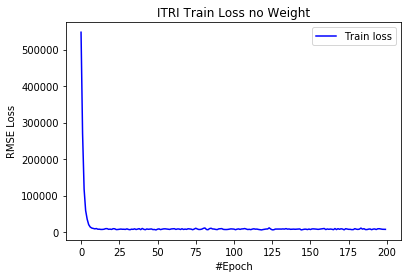

In [8]:
tf.reset_default_graph()

model = rrn.RRN(user_hparas=user_train_hparas, item_hparas=item_train_hparas, 
                user_vectors=user_vectors, item_vectors=item_vectors,
                is_train=True, lr=0.01, epochs=200, loss_function='rmse', weighted=None)

all_user_item_num = (len(userList), len(itemList))
model.train(df_train, user_map, item_map, initial_time, all_user_item_num, top_rank=None)
model.model_save('class_rmse')

train_loss = model.log['train_loss']
plt.plot(range(len(train_loss)), train_loss, color='blue', label='Train loss')
plt.title("ITRI Train Loss no Weight")
plt.legend(loc="upper right")
plt.xlabel('#Epoch')
plt.ylabel('RMSE Loss')
# plt.savefig("Train_Loss_with_weight_50.jpg")
plt.show()

# Test

In [9]:
tf.reset_default_graph()

model = rrn.RRN(user_hparas=user_test_hparas, item_hparas=item_test_hparas, 
                user_vectors=user_vectors, item_vectors=item_vectors,
                is_train=False, loss_function='rmse')

model.model_load('class_rmse')

test_rmse = model.test(df_test, user_map, item_map, initial_time, test_start_time, all_user_item_num)

print (sum(test_rmse)/len(test_rmse))

INFO:tensorflow:Restoring parameters from model/rrn_class_rmse.ckpt
0.240003352719


## Class dataset
**RMSE** (with weighted)

In [ ]:
tf.reset_default_graph()

model = rrn.RRN(user_hparas=user_test_hparas, item_hparas=item_test_hparas, 
                user_vectors=user_vectors, item_vectors=item_vectors,
                is_train=False, loss_function='log_loss')

model.model_load('class_log_loss')

for i in top_ranks:
    losses = model.test(df_test, user_map, item_map, initial_time, individually=True, top_rank=i)
    print ("top%d %s loss: %f" % (len(i), model.loss_function, sum(losses)/len(losses)))
    
print ()
losses = model.test(df_test, user_map, item_map, initial_time, individually=False, top_rank=None)
print ("All items %s loss: %f" % (model.loss_function, sum(losses)/len(losses)))

## Itri dataset 
**LOG_LOSS** (without weighted)

In [ ]:
tf.reset_default_graph()

model = rrn.RRN(user_hparas=user_test_hparas, item_hparas=item_test_hparas, 
                user_vectors=user_vectors, item_vectors=item_vectors,
                is_train=False, loss_function='log_loss')

model.model_load('itri_log_loss')

# for i in top_ranks:
#     losses = model.test(df_test, user_map, item_map, initial_time, individually=True, top_rank=i)
#     print ("top%d %s loss: %f" % (len(i), model.loss_function, sum(losses)/len(losses)))
    
# print ()
losses = model.test(df_test, user_map, item_map, initial_time, individually=False, top_rank=None)
print ("All items %s loss: %f" % (model.loss_function, sum(losses)/len(losses)))

## Itri dataset 
**LOG_LOSS** (with weighted)

In [ ]:
tf.reset_default_graph()

model = rrn.RRN(user_hparas=user_test_hparas, item_hparas=item_test_hparas, 
                user_vectors=user_vectors, item_vectors=item_vectors,
                is_train=False, loss_function='log_loss')

model.model_load('class_log_loss_weighted')

for i in top_ranks:
    losses = model.test(df_test, user_map, item_map, initial_time, individually=True, top_rank=i)
    print ("top%d %s loss: %f" % (len(i), model.loss_function, sum(losses)/len(losses)))
    
print ()
losses = model.test(df_test, user_map, item_map, initial_time, individually=False, top_rank=None)
print ("All items %s loss: %f" % (model.loss_function, sum(losses)/len(losses)))

# Debug Section

In [ ]:
tf.reset_default_graph()

model = rrn.RRN(user_hparas=user_test_hparas, item_hparas=item_test_hparas, 
                user_vectors=user_vectors, item_vectors=item_vectors,
                is_train=False, lr=0.01, epochs=100, loss_function='log_loss')
model.model_load('itri_log_loss')

In [ ]:
sequential_loss = []
prep = Preprocess(
    df_test, user_map, item_map, initial_time, 'rating', 
    user_time_interval=model.user_hparas['TIME_INTERVAL'], 
    item_time_interval=model.item_hparas['TIME_INTERVAL'])

user_input, item_input, ground_truth, batch_user, batch_item = prep.gen_batch(0)
u_static_vector = prep.get_latent_vector(batch_user, user_vectors, 'user')
i_static_vector = prep.get_latent_vector(batch_item, item_vectors, 'item')
weight_list = prep.get_list_weight(top_ranks[2], model.weighted)